In [1]:
using CePNEMAnalysis, StatsBase, Plots, Plots.PlotMeasures, ProgressMeter, CePNEM, MultivariateStats,
        ColorVectorSpace, MultipleTesting, HDF5, JLD2, Gen, ANTSUNData, FlavellConstants, UMAP, ImageShow, LinearAlgebra,
        ImageCore, Clustering, Images, GLMNet, Combinatorics, Distributions, FlavellBase, ProgressMeter, PyPlot, ANTSUNData, NeuroPALData,
        EncoderModel, AnalysisBase, HypothesisTests, MultipleTesting, PyCall, SpecialFunctions, FileIO, StatsPlots, TotalVariation, DelimitedFiles, Interpolations,
        GLM, DataFrames, KernelDensity, MultiKDE, Optim, ForwardDiff, HierarchicalPosteriorModel, ConnectomePlot, ColorTypes, Random, DataStructures


# Load data

This section loads all necessary data, including CePNEM model fits.

Expected runtime: 5-20 minutes

## Load raw CePNEM output data

This section loads the CePNEM output data. It is recommended to keep all parameters at default, but you should change the paths to the CePNEM fits and data files, as well as which datasets you want to use.

In [2]:
path_analysis_dict = "/data1/prj_kfc/data/analysis_dict/analysis_dict.jld2"
path_umap_dict = "/data1/prj_kfc/data/analysis_dict/umap_dict.jld2"
path_fit_results = "/data1/prj_kfc/data/analysis_dict/fit_results.jld2" # this notebook requires the full version of `fit_results`

"/data1/prj_kfc/data/analysis_dict/fit_results.jld2"

In [3]:
fit_results = Dict()
if isfile(path_fit_results)
    f = JLD2.jldopen(path_fit_results)
    fit_results = f["fit_results"]
    close(f)
end;

In [4]:
analysis_dict = Dict()
if isfile(path_analysis_dict)
    f = JLD2.jldopen(path_analysis_dict)
    analysis_dict = f["analysis_dict"]
    close(f)
end;

In [5]:
# analysis_dict_original = Dict()
# if isfile("/data1/prj_kfc/data/analysis_dict_backup/analysis_dict_nl10d.jld2")
#     f = JLD2.jldopen("/data1/prj_kfc/data/analysis_dict_backup/analysis_dict_nl10d.jld2")
#     analysis_dict_original = f["analysis_dict"]
#     close(f)
# end;

In [6]:
umap_dict = Dict()
if isfile(path_umap_dict)
    f = JLD2.jldopen(path_umap_dict)
    umap_dict = f["umap_dict"]
    close(f)
end;

In [7]:
θh_pos_is_ventral = analysis_dict["θh_pos_is_ventral"];

### Identify new datasets

If you later add new datasets and want to run this notebook on them, set this to the set of new datasets added to avoid recomputing things for datasets you've already analyzed. If you update the code or other methods and want to rerun everything fresh, set this to all datasets.

In [8]:
datasets_gfp = ["2022-01-07-03", "2022-03-16-01", "2022-03-16-02"]
datasets_baseline = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01", "2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"]
datasets_stim = ["2021-09-06-09", "2021-09-14-01", "2021-09-14-05", "2021-09-23-01", "2021-09-30-01"]
datasets_stim_1600 = ["2022-02-08-04", "2022-02-16-01", "2022-02-16-04", "2022-03-15-04", "2022-03-22-01", "2022-04-18-04"]
datasets_neuropal_1600 = ["2022-06-14-01", "2022-06-14-07", "2022-06-14-13", "2022-06-28-01", "2022-06-28-07", "2022-07-15-06", "2022-07-15-12", "2022-07-20-01", "2022-07-26-01", "2022-08-02-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21", "2023-01-19-01", "2023-01-19-08", "2023-01-19-22", "2023-01-09-28", "2023-01-17-01", "2023-01-19-15", "2023-01-23-01", "2023-03-07-01"];
datasets_neuropal_stim = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18", "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08", "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14", "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15", "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"]
datasets_neuropal_800 = []
datasets_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
datasets_baseline_1600 = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];

datasets_neuropal = deepcopy(datasets_neuropal_800)
append!(datasets_neuropal, datasets_neuropal_1600)
append!(datasets_neuropal, datasets_neuropal_stim)

datasets_gcamp = String[]
datasets_swf415 = String[]
datasets = String[]
for d in [datasets_baseline, datasets_stim, datasets_stim_1600]
    append!(datasets_gcamp, d)
    append!(datasets, d)
    append!(datasets_swf415, d)
end
append!(datasets, datasets_neuropal)
append!(datasets_gcamp, datasets_neuropal)
append!(datasets, datasets_gfp);

In [ ]:
datasets_compute = datasets;

## Compute UMAP

### Initialize UMAP space

To compute the UMAP, we first append the behaviors of each dataset together, then compute extrapolated model fits. (Note that in the paper, only a subset of 12 animals were used).

If you want to use the version of UMAP that is used in the paper, skip this section, download the `umap_dict.jld2` from wormwideweb.org and load it. Otherwise, you can run the UMAP computation yourself, but as UMAP is non-deterministic, you will get slightly different results.

TODO: Add a link to the UMAP file on wormwideweb.org

You can uncomment the lines of code to save the mean and variance of CePNEM fits if you are interested in them. By default, only the median fits will be saved since they are what is used to initialize the UMAP space.

In [ ]:
let
    median_CePNEM_fits, mean_CePNEM_fits, var_CePNEM_fits = compute_extrapolated_CePNEM_posterior_stats(fit_results, analysis_dict, datasets_compute, θh_pos_is_ventral)
    add_to_analysis_dict!(umap_dict, median_CePNEM_fits, "median_CePNEM_fits");
    # add_to_analysis_dict!(umap_dict, mean_CePNEM_fits, "mean_CePNEM_fits");
    # add_to_analysis_dict!(umap_dict, var_CePNEM_fits, "var_CePNEM_fits");
end


Progress: 100%|█████████████████████████████████████████| Time: 5:51:02


In [ ]:
umap_dict["median_CePNEM_fits_all"] = append_median_CePNEM_fits(fit_results, analysis_dict, umap_dict, datasets_compute);

In [ ]:
umap_dict["extrapolated_umap_median"] = UMAP_(transpose(umap_dict["median_CePNEM_fits_all"]));

UMAP_{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}, Matrix{Float64}, LinearAlgebra.Transpose{Float64, Matrix{Float64}}, Matrix{Int64}, Matrix{Float64}}(sparse([143, 315, 327, 331, 718, 1554, 1621, 2689, 2788, 2936  …  369, 394, 406, 626, 933, 1297, 1412, 1883, 3087, 3609], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4004, 4004, 4004, 4004, 4004, 4004, 4004, 4004, 4004, 4004], [1.0, 0.12563503631169923, 0.04500424420243436, 0.248853287107852, 0.09881716215641062, 0.27863798505636217, 0.23177609717172515, 0.13356608819187682, 0.502757786591219, 0.13097619557783785  …  0.24338357807069771, 0.12702863302366585, 0.30546075774233183, 0.2091148591355654, 0.25880862347327366, 0.24079151375108157, 0.3218859053925887, 0.19859074718993092, 0.2077727825980203, 1.0], 4004, 4004), [0.4744900875637339 -1.2756519087766582 … 3.8878061483133455 0.34739016354309205; 3.046838790154551 -0.8668094526454321 … -3.2709499277006095 -6.769824955650255], [0.031159141749095856 0.03273375999056292 … 0.09958213231058

### Project new datasets into UMAP space

In [15]:
add_to_analysis_dict!(umap_dict, project_CePNEM_to_UMAP(fit_results, analysis_dict, umap_dict, datasets_compute, θh_pos_is_ventral), "umap_extrap_all_median");

### Project hierarchical model fits into UMAP space

In [23]:
for k = ["", "_stimonly", "_all", "_stim2", "_baselineonly"]
    all_behs = analysis_dict["extrapolated_behaviors"]
    umap_dict["hierarchical_umap$k"] = Dict()
    @showprogress for neuron = keys(analysis_dict["matches"])
        if neuron in keys(analysis_dict["hierarchical_model_params$k"])
            umap_dict["hierarchical_umap$k"][neuron] = Dict()
            signals = Float64[]
            for (i, (dataset, rng, n)) in enumerate(analysis_dict["hierarchical_datasets$k"][neuron])
                ps = deepcopy(convert_hbparams_to_ps(analysis_dict["hierarchical_model_params$k"][neuron].x[i]))
                ps[3] = -ps[3] # UMAP expects ventral to be positive
                model = model_nl8(size(all_behs,1), ps..., all_behs[:,1], all_behs[:,2], all_behs[:,3])
                extrap = zeros(size(all_behs, 1), 20)
                # can't project one point at a time into UMAP
                for j=1:20
                    extrap[:,j] .= (model .- mean(model)) .* analysis_dict["signal"][dataset][n]
                end
                push!(signals, analysis_dict["signal"][dataset][n])
                umap_dict["hierarchical_umap$k"][neuron][(dataset, rng, n)] = mean(UMAP.transform(umap_dict["extrapolated_umap_median"], extrap), dims=2)[:,1]
            end
            ps = deepcopy(convert_hbparams_to_ps(analysis_dict["hierarchical_model_params$k"][neuron].mu))
            ps[3] = -ps[3] # UMAP expects ventral to be positive
            model = model_nl8(size(all_behs,1), ps..., all_behs[:,1], all_behs[:,2], all_behs[:,3])
            extrap = zeros(size(all_behs, 1), 20)
            for j=1:20
                extrap[:,j] .= (model .- mean(model)) .* mean(signals)
            end
            umap_dict["hierarchical_umap$k"][neuron]["mu"] = mean(UMAP.transform(umap_dict["extrapolated_umap_median"], extrap), dims=2)[:,1]
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:14
Progress: 100%|█████████████████████████████████████████| Time: 0:03:50
Progress: 100%|█████████████████████████████████████████| Time: 0:07:59
Progress: 100%|█████████████████████████████████████████| Time: 0:01:58
Progress: 100%|█████████████████████████████████████████| Time: 0:04:14


In [26]:
for k = ["", "_stimonly", "_all", "_stim2", "_baselineonly"]
    all_behs = analysis_dict["extrapolated_behaviors"]
    @showprogress for neuron = keys(analysis_dict["matches"])
        if neuron in keys(analysis_dict["hierarchical_model_params$k"])
            ps = deepcopy(compute_cartesian_average(analysis_dict["hierarchical_model_params$k"][neuron]))
            ps[3] = -ps[3] # UMAP expects ventral to be positive
            model = model_nl8(size(all_behs,1), ps..., all_behs[:,1], all_behs[:,2], all_behs[:,3])
            extrap = zeros(size(all_behs, 1), 20)
            signals = Float64[]
            for (i, (dataset, rng, n)) in enumerate(analysis_dict["hierarchical_datasets$k"][neuron])
                push!(signals, analysis_dict["signal"][dataset][n])
            end
            for j=1:20
                extrap[:,j] .= (model .- mean(model)) .* mean(signals)
            end
            umap_dict["hierarchical_umap$k"][neuron]["mu_cart"] = mean(UMAP.transform(umap_dict["extrapolated_umap_median"], extrap), dims=2)[:,1]
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


## Plot UMAP

### Set UMAP plotting parameters

In [18]:
umap_dict["umap_xmin"] = -8
umap_dict["umap_xmax"] = 8
umap_dict["umap_xstep"] = 0.05
umap_dict["umap_xaxis"] = umap_dict["umap_xmin"]:umap_dict["umap_xstep"]:umap_dict["umap_xmax"]
umap_dict["umap_ymin"] = -8
umap_dict["umap_ymax"] = 8
umap_dict["umap_ystep"] = 0.05
umap_dict["umap_yaxis"] = umap_dict["umap_ymin"]:umap_dict["umap_ystep"]:umap_dict["umap_ymax"];

### Compute sub-UMAPs with encodings and encoding changes

This allows us to plot the locations of each encoding type in the UMAP space. You can change `datasets_baseline` to some other set of datasets to find the UMAP projections of those datasets (eg: to make Figures S3A-S3C and S6J). You can also set `use_median=true` to compute the median location of each neuron in UMAP space instead of the full posterior, to construct Figure S3D.

In [11]:
compute_umap_subcategories!(fit_results, analysis_dict, umap_dict, datasets_baseline, use_median=false);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


### Figure 3A: Plot full UMAP space

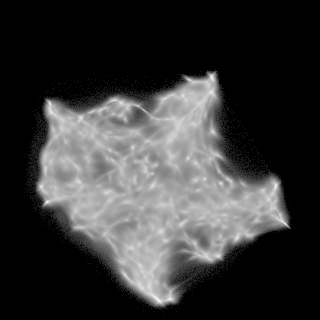

In [13]:
let
    save_fig = false # set to true to save the figure
    rgb = mapc.(v->min(v,1.), make_umap_rgb([umap_dict["umap_hist_weights_median"]], [(1,1,1)], umap_dict["umap_hist_weights_median"], (1,1,1), 0.))

    if save_fig
        Images.save(joinpath(path_fig_root, "figure3/full_umap.pdf"), rgb)
        Images.save(joinpath(path_fig_root, "figure3/full_umap.png"), rgb)
    end
    rgb
end

### Figures 3B, 3D, and 3E: Plot projections of behaviors in UMAP space

In [14]:
umap_dict["v_subrng"] = (80:230,10:160);

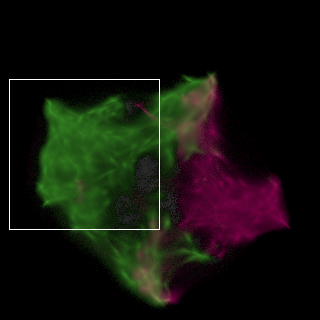

In [19]:
let
    beh = "v" # Set this to either "v", "hc", or "P"
    save_fig = false # set to true to save the figure

    key_weights = "umap_hist_weights_median"
    beh_ = (beh == "hc" ? "θh" : beh)
    sub_behs = Dict(
        "v" => ("rev", "fwd"),
        "hc" => ("ventral", "dorsal"),
        "P" => ("inh", "act")
    )
    v_subrng = umap_dict["v_subrng"]
    
    rgb = mapc.(v->min(v,1.), make_umap_rgb([umap_dict["umap_hist_weights_cats_median"][beh_][sub_behs[beh][1]],
            umap_dict["umap_hist_weights_cats_median"][beh_][sub_behs[beh][2]]], 
            [color_to_rgba(palette(:PiYG)[1],1)[1:3], 1.5 .*color_to_rgba(palette(:PiYG)[end],1)[1:3]], 
            umap_dict[key_weights], (1,1,1), 0.2))
    
    if beh == "v"
        rgb[v_subrng[1], v_subrng[2][1]] .= RGB(1,1,1)
        rgb[v_subrng[1], v_subrng[2][end]] .= RGB(1,1,1)
        rgb[v_subrng[1][1], v_subrng[2]] .= RGB(1,1,1)
        rgb[v_subrng[1][end], v_subrng[2]] .= RGB(1,1,1)
    end
    
    # zoom level to Adobe Illustrator = 36%
    if save_fig
        Images.save(joinpath(path_fig_root, "figure3/$(beh)_umap.pdf"), rgb)
        Images.save(joinpath(path_fig_root, "figure3/$(beh)_umap.png"), rgb)
    end
    rgb
end

### Figure 3C: EWMA projection into UMAP space

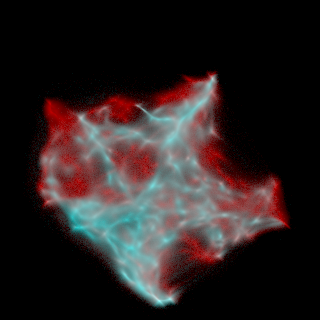

In [21]:
let
    save_fig = false # set to true to save the figure
    rgb = make_umap_rgb([sum(umap_dict["umap_hist_weights_ewma_median"][1:4,:,:], dims=1)[1,:,:], sum(umap_dict["umap_hist_weights_ewma_median"][5:end,:,:], dims=1)[1,:,:]], [(0.8,0,0), (0,1,1)], umap_dict["umap_hist_weights_median"], (1,1,1), 0.2)
    if save_fig
        Images.save(joinpath(path_fig_root, "figure3/umap_ewma.pdf"), rgb)
        Images.save(joinpath(path_fig_root, "figure3/umap_ewma.png"), rgb)
    end
    rgb
end

### Figure 3F: Velocity rectification projections into UMAP space

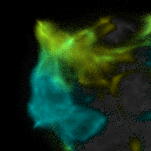

In [22]:
let
    save_fig = false # set to true to save the figure
    v_subrng = umap_dict["v_subrng"]
    key_weights = "umap_hist_weights_median"
    key_subcats = "umap_hist_weights_subcats_median"

    rgb = mapc.(v->min(v,1.), make_umap_rgb([umap_dict[key_subcats]["v"]["fwd_slope_pos_rect_pos"], umap_dict[key_subcats]["v"]["analog_pos"], umap_dict[key_subcats]["v"]["rev_slope_pos_rect_neg"]], 
        [(0.5,0.5,0), 1.5 .*color_to_rgba(palette(:PiYG)[end],1)[1:3], (0,0.7,0.7)], umap_dict[key_weights], (1,1,1), 0.2)[v_subrng[1], v_subrng[2]])
        
    if save_fig
        Images.save(joinpath(path_fig_root, "figure3/v_subcat_umap.pdf"), rgb)
        Images.save(joinpath(path_fig_root, "figure3/v_subcat_umap.png"), rgb)
    end
    
    rgb
end
        

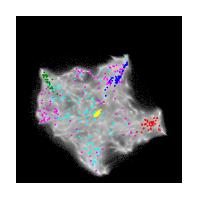

In [27]:
let
    savefig = false # set to true to save the figure
    key = ""
    rgb = mapc.(v->min(v,1.), make_umap_rgb([umap_dict["umap_hist_weights_median"]], [(1,1,1)], umap_dict["umap_hist_weights_median"], (1,1,1), 0.))

    neurons = ["RIM", "RIB", "MC", "IL2D", "OLQD", "URX"]
    colors = [:red, :green, :blue, :yellow, :magenta, :cyan]
    
    Plots.plot(umap_dict["umap_xaxis"], umap_dict["umap_yaxis"], rgb, size=(200,200), axis=nothing, border=:none)
    for (i,neuron) = enumerate(neurons)
        for k in keys(umap_dict["hierarchical_umap$key"][neuron])
            if !(k in ["mu", "mu_cart"])
                Plots.scatter!([umap_dict["hierarchical_umap$key"][neuron][k][1]], [-umap_dict["hierarchical_umap$key"][neuron][k][2]], 
                    markersize=1, markerstrokecolor=colors[i], markerstrokewidth=0.5, markerstrokestyle=:solid, 
                    marker=(:circle, 1, colors[i]), label=nothing)
            end
        end
    end
    if savefig
        Plots.savefig(joinpath(path_fig_root, "figure6/umap_variability.pdf"))
    end
    Plots.plot!()
end


## TODO: Make sure the following code is still valid

In [29]:
neuropal_umap_key_datasets = Dict()
let
    key = "umap_extrap_all_median"
    key_datasets = ["2022-08-02-01"]
    key_ranges = [2]
    @showprogress for neuron_label in keys(analysis_dict["matches"])
        neurons = []
        for dataset in key_datasets
            found = []
            for (dset, n) in analysis_dict["matches"][neuron_label]
                if dset == dataset
                    push!(found, n)
                end
            end
            if length(found) > 0
                push!(neurons, found)
            end
        end
        if length(neurons) < length(key_datasets)
            continue
        end
        if neuron_label == "I6"
            println(neurons)
        end
        hist_fits = []
        for i=1:length(key_datasets)
            dataset = key_datasets[i]
            rng = key_ranges[i]
            found = false
            for neuron in neurons[i]
                if !(neuron in analysis_dict["neuron_categorization"][dataset][rng]["all"])
                    continue
                end
                hist_fit = fit(Histogram, (umap_dict[key][dataset][rng][neuron][1,:], umap_dict[key][dataset][rng][neuron][2,:]), (umap_dict["umap_xaxis"], umap_dict["umap_yaxis"])).weights
                if !found
                    push!(hist_fits, hist_fit)
                    found = true
                else
                    hist_fits[end] .+= hist_fit
                end
            end
        end
        if length(hist_fits) > 0
            neuropal_umap_key_datasets[neuron_label] = hist_fits
        end
    end
end
            

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


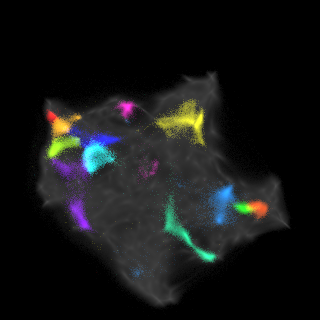

In [33]:
let
    savefig = false # set to true to save the figure
    colors = [(1,0,0), (1,0.25,0), (1,2/3,0), (1,1,0), (0.6,1,0), (0,1,0), (0,1,0.6), (0,1,1), (0,0.5,1), (0,0,1), (0.5,0,1), (1,0,0.8), (1,1,1)]
    rgb = make_umap_rgb(neuropal_umap_key_datasets["RIB"], [colors[1]], umap_dict["umap_hist_weights_median"], (1,1,1), 0.)
    
    for (i,neuron) in enumerate(["AVA", "RID", "MC", "AIM", "AIB", "SMDV", "AUA", "SAAV", "SAADL", "RMDD", "SMDD"])
        rgb .+= make_umap_rgb(neuropal_umap_key_datasets[neuron], [colors[i+1]], umap_dict["umap_hist_weights_median"], (1,1,1), 0.)
    end
    rgb .+= make_umap_rgb([umap_dict["umap_hist_weights_median"]], [(0.3, 0.3, 0.3)], umap_dict["umap_hist_weights_median"], (1,1,1), 0.)
    rgb = mapc.(v->min(v,1.), rgb)
    if savefig
        Images.save(joinpath(path_fig_root, "figureS5/neuropal_umap.pdf"), rgb)
    end
    rgb
end

# Save your data

In [34]:
JLD2.@save(path_umap_dict, umap_dict); 